In [4]:
import pandas as pd
import numpy as np
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm


In [5]:
df = pd.read_csv("../data/prepped_data.csv", index_col = 0, low_memory = False)

df = df.drop(columns=['policy_nr_hashed', 'last_data_year', 'first_data_year', 'control_group'])

# Filter rows where 'welcome_discount' is 1
df = df[df["welcome_discount"] == 1]


# Feature type identification

In [6]:
categorical_features = []
continuous_features = []
binary_features = []

# Define a threshold for the maximum number of unique values for a categorical column
max_unique_values_for_categorical = 10

# Iterate through each column to determine if it's categorical, continuous, or binary
for column in df.columns:
    unique_values = df[column].nunique()
    if unique_values == 2:
        # If exactly 2 unique values, treat column as binary
        binary_features.append(column)
    elif (df[column].dtype == 'object' or unique_values <= max_unique_values_for_categorical) and unique_values > 2:
        # If object type or up to the threshold of unique values (and more than 2), treat as categorical
        categorical_features.append(column)
    else:
        # Otherwise, treat as continuous
        continuous_features.append(column)

print(f'Binary Features: {binary_features}')


categorical_features.remove('years_since_last_car_change')
print(f'Categorical Features: {categorical_features}')
print(f'Continuous Features: {continuous_features}')
continuous_features.append( 'years_since_last_car_change')

Binary Features: ['churn', 'last_allrisk basis', 'last_allrisk compleet', 'last_allrisk royaal', 'last_wa-extra', 'fake_alarm', 'policyholder_change', 'lpa']
Categorical Features: ['last_brand', 'last_type', 'last_fuel_type', 'last_postcode', 'last_product', 'nr_cars', 'max_nr_coverages', 'last_nr_coverages', 'last_trend_nr_coverages', 'last_year_car_change', 'n_last_vs_peak']
Continuous Features: ['welcome_discount', 'first_premium', 'last_premium', 'first_split', 'last_split', 'last_customer_age', 'last_accident_free_years', 'last_car_value', 'last_age_car', 'last_weight', 'accident_years', 'last_change_premium_abs', 'last_change_premium_perc', 'last_vs_first_split', 'cum_change_premium_abs', 'cum_change_premium_perc']


# Splitting Train/Test

In [7]:
from sklearn.model_selection import train_test_split
y = df['churn']
X = df.drop(columns=['churn'])


for cat in categorical_features:
     X[cat] = X[cat].astype("category")



#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

y_test.shape


(22262,)

In [8]:
# Assuming y_train is your training target variable
number_of_positive_instances = sum(y_train == 1)
number_of_negative_instances = sum(y_train == 0)

# Calculate the scale_pos_weight value
scale_pos_weight_value =  number_of_negative_instances /  number_of_positive_instances 

print(f"Suggested scale_pos_weight value: {scale_pos_weight_value}")


Suggested scale_pos_weight value: 3.8041990381058084


# Tuning Hyperparameters & Training the model

In [18]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, make_scorer
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Define the search space
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'min_child_weight': hp.quniform('min_child_weight', 8, 20, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}


        
def objective(space):
    model = XGBClassifier(
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        learning_rate=space['learning_rate'],
        subsample=space['subsample'],
        gamma=space['gamma'],
        colsample_bytree=space['colsample_bytree'],
        min_child_weight = space['min_child_weight'],
        reg_alpha=space['reg_alpha'],
        # scale_pos_weight=scale_pos_weight_value,
        reg_lambda=space['reg_lambda'],
        objective='binary:logistic',
        tree_method='hist',
        enable_categorical=True 
    )
    
    # Using cross-validation for evaluation
    score = cross_val_score(model, X_train, y_train, cv=5, scoring = 'neg_brier_score' ).mean()

    # We aim to maximize f1, hence we return its negative value
    return {'loss': - score, 'status': STATUS_OK}

# Run the algorithm
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

print("Best parameters:", best)



 

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [07:03<00:00,  8.47s/trial, best loss: 0.09632569667179236]
Best parameters: {'colsample_bytree': 0.5941498434681705, 'gamma': 0.21923895817243172, 'learning_rate': 0.08910368025072707, 'max_depth': 9.0, 'min_child_weight': 10.0, 'n_estimators': 110.0, 'reg_alpha': 0.2578717329746613, 'reg_lambda': 0.4534360608574718, 'subsample': 0.8379228123992896}


# Evaluation metrics & Optimal hyperparameters

In [10]:

#Best parameters brier: {'colsample_bytree': 0.6214603166799485, 'gamma': 0.09327251345789303, 'learning_rate': 0.19861493186183998, 'max_depth': 10.0, 'min_child_weight': 9.0, 'n_estimators': 176.0, 'reg_alpha': 0.18239980169633493, 'reg_lambda': 0.7207028599747125, 'subsample': 0.8797605417401115}


CV Average logloss: -0.3231
CV mean_absolute_error: 0.1937
CV Average  brier score: -0.0963
CV median_absolute_error: 0.0865


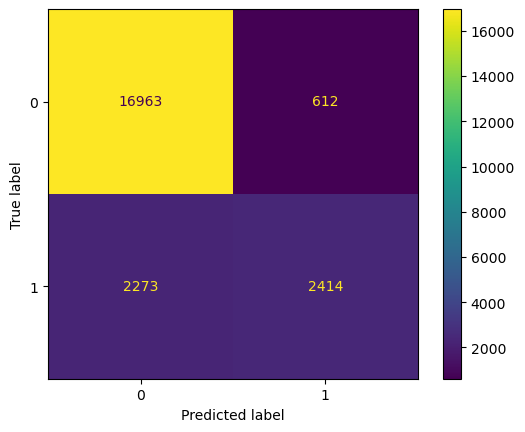

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, average_precision_score, median_absolute_error, mean_absolute_error

# Use the best parameters
model = XGBClassifier(
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    learning_rate=best['learning_rate'],
    subsample=best['subsample'],
    gamma=best['gamma'],
    colsample_bytree=best['colsample_bytree'],
    min_child_weight = best['min_child_weight'],
    # scale_pos_weight=scale_pos_weight_value,
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    objective='binary:logistic',
    tree_method='hist',
    enable_categorical = True
)

# Fit the model
model.fit(X_train, y_train)

# Make predictions
# preds = model.predict_proba(X_test)

threshold = 0.5
probabilities = model.predict_proba(X_test)[:, 1]
preds = np.abs(np.ceil(np.array(probabilities) - threshold)).astype("int")

def mae_prob(y_true, y_pred_probs):
    return mean_absolute_error(y_true, y_pred_probs)

def medae_prob(y_true, y_pred_probs):
    return median_absolute_error(y_true, y_pred_probs)

mae_prob_scorer = make_scorer(mae_prob, needs_proba=True)
medae_prob_scorer = make_scorer(medae_prob, needs_proba=True)

logloss_score = cross_val_score(model, X, y, scoring= 'neg_log_loss')
brier_score = cross_val_score(model, X, y, cv = 5, scoring = 'neg_brier_score')
scores_mae = cross_val_score(model, X, y, cv=5, scoring=mae_prob_scorer)
scores_medae = cross_val_score(model, X, y, cv=5, scoring=medae_prob_scorer)


# scores_custom = cross_val_score(model, X, y, cv=5, scoring=custom_cost_score)

conf_matrix = confusion_matrix(y_test, preds)



print('CV Average logloss: {0:0.4f}'.format(np.mean(logloss_score)))
print('CV mean_absolute_error: {0:0.4f}'.format(np.mean(scores_mae)))
print('CV Average  brier score: {0:0.4f}'.format(np.mean(brier_score)))
print('CV median_absolute_error: {0:0.4f}'.format(np.mean(scores_medae)))


# print('CV Average Custom score: {0:0.4f}'.format(np.mean(scores_custom)))

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()

[0.         0.00592792 0.00707575 0.00831849 0.00975412 0.00684497
 0.00567808 0.00496724 0.00584166 0.00526499 0.01292222 0.00491658
 0.007846   0.00680721 0.31052446 0.00511426 0.02187019 0.01544255
 0.01200316 0.01531193 0.         0.00560367 0.01220431 0.00925822
 0.10686614 0.0101681  0.02812911 0.01100627 0.01265044 0.03043423
 0.02136151 0.00939755 0.25180036 0.00797743 0.01071086]


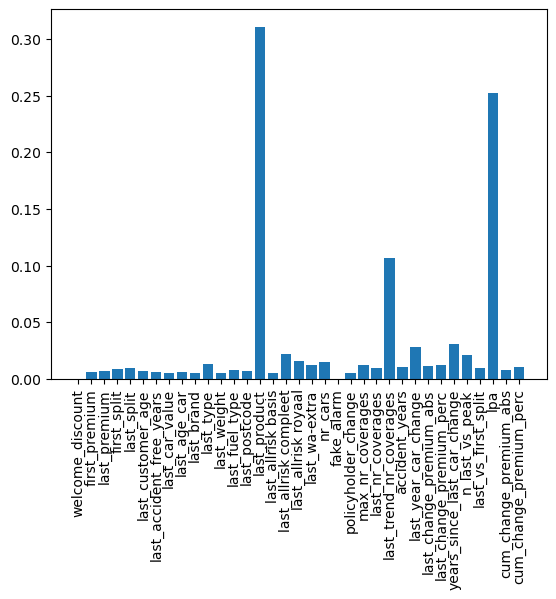

In [26]:
import matplotlib.pyplot as pyplot

# Now you can use plt to create plots

print(model.feature_importances_)
# plot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.xticks(range(len(model.feature_importances_)), X.columns, rotation='vertical')
pyplot.show()
